# Black Panther Dataset Generation for v0.3

Exploration analysis on the user-impressions via `mistplay_android_kinesis`. Big Query Impressions from the previous iteration has been deprecated.

We then merge this with the user-installs (AWS, Athena), which corresponds to the positive labels.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyathena
from pyathena.pandas_cursor import PandasCursor # speeds up Pyathena
from pyathena import cursor
from pyathena import connect
from datetime import datetime

## Query the installs and impressions info on Athena
We need the **installs** table to get more info on the <font color=red>**Users** </font>, e.g. to determine the positive labels. We fetch the **impressions** table o get more info on the <font color=red>**Offers** </font>. For isntance, we need to determine which *pid* is linked to the *impression_offer* (=*oid_nid*) from BigQuery. Also, future information of the previous performance of an offer (*CPM*, *conversion*) is given in the latter. <br>

We also fetch extra information to weight on the loss function of our ML models. We can penalise either users for being poorly active or non-spenders, as well as penalising offers showing poor CPM or with low payout. From the installs table, we can bonify/penalise a **user's install** based on:
1. Client's revenue : a user-spender should weight favorably
2. User's play time : an active user should also weight favorably
<br>

From the impressions table, we can bonify/penalise **an active offer** based on:
1. Installs/Impressions : a good CPM offer should be weighted favirably
2. CPI : a high pay-out game should be weighted favorably

In [2]:
user_impressions_query = """SELECT * FROM mistylearning.blackpanther_user_impressions"""

users_query = """SELECT * FROM mistylearning.blackpanther_user_data"""

user_installs_query = """SELECT * FROM mistylearning.blackpanther_user_installs"""

offer_impressions_query = """SELECT * FROM mistylearning.blackpanther_offer_data"""

default_muse_query =   """SELECT lctr
                        , AVG(u0 ) u0 
                        , AVG(u1 ) u1 
                        , AVG(u2 ) u2 
                        , AVG(u3 ) u3 
                        , AVG(u4 ) u4 
                        , AVG(u5 ) u5 
                        , AVG(u6 ) u6 
                        , AVG(u7 ) u7 
                        , AVG(u8 ) u8 
                        , AVG(u9 ) u9 
                        , AVG(u10) u10
                        , AVG(u11) u11
                        , AVG(u12) u12
                        , AVG(u13) u13
                        , AVG(u14) u14
                        , AVG(u15) u15
                        , AVG(u16) u16
                        , AVG(u17) u17
                        , AVG(u18) u18
                        , AVG(u19) u19
                        , AVG(u20) u20
                        , AVG(u21) u21
                        , AVG(u22) u22
                        , AVG(u23) u23
                        , AVG(u24) u24
                        , AVG(u25) u25
                        , AVG(u26) u26
                        , AVG(u27) u27
                        , AVG(u28) u28
                        , AVG(u29) u29
                        , AVG(u30) u30
                        , AVG(u31) u31
                        , AVG(u32) u32
                        , AVG(u33) u33
                        , AVG(u34) u34
                        FROM mistylearning.muse_v0_9e
                        LEFT JOIN mistplayetl.users
                        USING (uid)
                        WHERE lctr != 'KR'
                        GROUP BY lctr
                        """

In [6]:
conn = connect(s3_staging_dir='s3://aws-athena-query-results-732179175681-us-west-2')

cursor = connect(s3_staging_dir='s3://aws-athena-query-results-732179175681-us-west-2').cursor(PandasCursor)

## Our Final Relevant Tables

Below we pickle different tables for speed. 

#### User Impressions

In [13]:
# only run this once to create pickle file

begin = datetime.now()

user_impressions = cursor.execute(user_impressions_query).as_pandas()

user_impressions.to_pickle('user_impressions.pkl')

print("Total Runtime = %s" % str(datetime.now()-begin))

Total Runtime = 0:04:03.532774


In [4]:
user_impressions = pd.read_pickle('user_impressions.pkl')

In [5]:
user_impressions.head()

,uid,ts,oid_nid
0,b3e8af6f-a2bf-4335-b1f3-e283e7530965,1612243154378,6060_mistplay
1,b3e8af6f-a2bf-4335-b1f3-e283e7530965,1612243154378,4930_mistplay
2,a8f7340b-5a0e-4fff-884a-2046082917a3,1612243095406,1760_mistplay
3,e7b73401-ef2d-4b7a-9642-4e06e81b57a8,1612243154267,298_mistplay
4,018a5744-7677-4aae-b011-480adb4e425f,1612243153940,4706_mistplay


#### Users

In [ ]:
# only run this once to create pickle file

begin = datetime.now()

users = cursor.execute(users_query).as_pandas()

users.to_pickle('users.pkl')

print("Total Runtime = %s" % str(datetime.now()-begin))

In [6]:
users = pd.read_pickle('users.pkl')

In [7]:
users.head()

,uid,country,ldu,os,age,female,male,organic,u0,u1,...,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34
0,f803fce1-61b9-4fc1-bc31-5bb827523252,US,samsung_SM-N981U,11,37,1,0,0,-0.274783,0.486844,...,-0.830549,-0.394699,0.388901,0.494957,0.227730,-0.250627,0.521675,-0.482543,0.608605,-0.413082
1,14558101-043d-40b3-a793-b6804d7c42c4,US,LGE_LGL423DL,8,57,1,0,0,-0.266697,0.481701,...,-0.702249,-0.410674,0.565572,0.478308,0.271342,-0.205924,0.572086,-0.332380,0.609803,-0.634999
2,183bc08f-2b74-403c-87b3-a339117f087e,US,samsung_SM-G950U,<NA>,23,1,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195e805e-25ef-434a-aa18-497d262ca657,US,samsung_SM-A205U,10,24,1,0,0,-0.329588,0.275809,...,-0.669658,-0.532271,0.350009,0.325083,0.246437,0.016243,0.358545,-0.140637,0.452213,-0.443795
4,197fe555-9aa4-4bb1-b1b0-15f129af4108,US,samsung_SM-G965U,10,27,0,1,0,-0.243082,0.225123,...,-0.549037,-0.346430,0.358939,0.463867,0.286116,-0.209698,0.299198,0.163154,0.564883,-0.529973


#### User Installs

In [19]:
# only run this once to create pickle file

begin = datetime.now()

user_installs = cursor.execute(user_installs_query).as_pandas()

user_installs.to_pickle('user_installs.pkl')

print("Total Runtime = %s" % str(datetime.now()-begin))

Total Runtime = 0:00:28.167411


In [8]:
user_installs = pd.read_pickle('user_installs.pkl')

In [9]:
user_installs.head()

,uid,oid_nid,install_date,d0_time,d7_time,d0_spend,label_install
0,cf776590-4b43-469e-a7a8-16e55f40491b,4172_mistplay,2021-02-03,5618263,7231097,1.99,1
1,d07f27dc-ad65-4fda-b257-b7feae614a6a,12102_mistplay,2021-02-02,12817456,17435639,0.00,1
2,e5daac47-fb32-4fe1-9280-8d49eeef0fcc,7184_mistplay,2021-02-02,4446395,5017702,1.98,1
3,ec5aaddb-413c-4f74-90aa-0039f0c1e528,12083_mistplay,2021-02-06,147655,147655,0.00,1
4,eeb95375-2240-4136-a114-8b640d679a08,6010_mistplay,2021-02-05,1468546,8382749,0.00,1


#### Offer Impressions

In [ ]:
# only run this once to create pickle file

begin = datetime.now()

offer_impressions = cursor.execute(offer_impressions_query).as_pandas()

offer_impressions.to_pickle('offer_impressions.pkl')

print("Total Runtime = %s" % datetime.now()-begin)

In [10]:
offer_impressions = pd.read_pickle('offer_impressions.pkl')

In [11]:
offer_impressions.head()

,oid_nid,pid,ecpm,cpi,um,d0,d1,d2,d3,d4,...,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34
0,5116_mistplay,com.amanotes.pamadancingroad,0.002444,0.45,0.5,0.443365,-0.759197,-0.126997,0.714281,-0.242982,...,-0.484963,-0.305180,0.404799,0.355554,-0.268200,0.24420,0.118251,0.261714,0.618078,-0.578555
1,5122_mistplay,com.amanotes.pamadancingroad,0.002913,0.30,0.5,0.443365,-0.759197,-0.126997,0.714281,-0.242982,...,-0.484963,-0.305180,0.404799,0.355554,-0.268200,0.24420,0.118251,0.261714,0.618078,-0.578555
2,5114-e_mistplay,com.amanotes.pamadancingroad,0.000776,0.35,0.5,0.443365,-0.759197,-0.126997,0.714281,-0.242982,...,-0.484963,-0.305180,0.404799,0.355554,-0.268200,0.24420,0.118251,0.261714,0.618078,-0.578555
3,5051_mistplay,com.amanotes.pamadancingroad,0.001602,0.25,0.5,0.443365,-0.759197,-0.126997,0.714281,-0.242982,...,-0.484963,-0.305180,0.404799,0.355554,-0.268200,0.24420,0.118251,0.261714,0.618078,-0.578555
4,6050_mistplay,com.amanotes.pamainfinitybounce,NaN,0.13,0.5,0.399485,-0.513746,-0.278114,0.501481,-0.593255,...,-0.144306,0.013715,0.353296,0.216668,-0.184181,-0.13385,0.084655,0.531674,0.491229,-0.279619


#### Muse Vectors 

In [ ]:
# only run this once to create pickle file

begin = datetime.now()

default_muse = cursor.execute(default_muse_query).as_pandas()

default_muse.to_pickle('default_muse.pkl')

print("Total Runtime = %s" % str(datetime.now()-begin))

In [12]:
default_muse = pd.read_pickle('default_muse.pkl')

In [13]:
default_muse.head()

,lctr,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,u25,u26,u27,u28,u29,u30,u31,u32,u33,u34
0,JP,-0.087031,0.036619,-0.177851,0.230355,0.025332,-0.115786,-0.005574,0.111414,0.258830,...,-0.365581,-0.205909,0.269093,0.282815,0.205036,0.063490,0.189686,0.176682,0.294146,-0.274549
1,BQ,-0.018198,-0.106642,-0.211958,0.243214,0.190950,-0.201725,-0.058967,0.197966,0.265520,...,-0.501122,-0.326076,0.358922,0.315438,0.227963,0.118120,0.317050,0.110043,0.425786,-0.301686
2,HK,-0.048925,0.050159,-0.152087,0.235962,0.039899,-0.137089,0.067649,0.107315,0.237422,...,-0.357831,-0.262153,0.250766,0.277851,0.250897,0.103934,0.238277,0.174968,0.297060,-0.279566
3,PR,-0.160216,0.099248,-0.291530,0.240551,0.223786,-0.054053,-0.242586,0.233818,0.180189,...,-0.458384,-0.253308,0.337547,0.364415,0.216018,0.000249,0.352178,-0.120056,0.399248,-0.331115
4,BM,0.098879,-0.076338,-0.237841,0.204494,0.122899,-0.147690,-0.151892,0.214366,0.128223,...,-0.469821,-0.284202,0.373319,0.331949,0.210501,0.005368,0.311417,0.039305,0.382418,-0.326953


## Prepping the Labeled Dataset
Merge the user's installs and impressions info. Add the pids that haven't seen any installs.

In [14]:
print('US user impressions : ', user_impressions.shape[0])
print('US user installs : ', user_installs.shape[0])
print('US offer CPM stats : ', offer_impressions.shape[0])

US user impressions :  22749625
US user installs :  241189
US offer CPM stats :  3136


In [15]:
df = pd.merge(user_installs, user_impressions, 
              how='right',
              left_on=['uid','oid_nid'],
              right_on = ['uid','oid_nid']) # adds the pids that have not gotten any installs
df = pd.merge(df, offer_impressions, how='left', on='oid_nid')

In [16]:
# drop some discover weekly unknow pids
df = df[~df.pid.isnull()].copy()

In [17]:
# fill the other NaNs with 0s (revenue, client's revenue and negative label)
df[['d0_time', 'd7_time', 'd0_spend','label_install','ecpm']] = df[['d0_time', 'd7_time', 'd0_spend','label_install','ecpm']].fillna(0).copy()

df['um'] = df['um'].fillna(0.5).copy()

In [18]:
df.head()

,uid,oid_nid,install_date,d0_time,d7_time,d0_spend,label_install,ts,pid,ecpm,...,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34
0,cf776590-4b43-469e-a7a8-16e55f40491b,4172_mistplay,2021-02-03,5618263,7231097,1.99,1,1612333875556,com.superplaystudios.dicedreams,0.058709,...,-0.471526,0.291392,0.193514,0.765365,0.308161,0.085101,0.382914,-0.175286,0.134823,0.183003
1,d07f27dc-ad65-4fda-b257-b7feae614a6a,12102_mistplay,2021-02-02,12817456,17435639,0.00,1,1612280725299,com.king.candycrushsaga,0.050208,...,-1.003834,-0.642976,0.445653,0.485739,0.226179,-0.258524,0.450482,-0.429882,0.645425,-0.473596
2,d07f27dc-ad65-4fda-b257-b7feae614a6a,12102_mistplay,2021-02-02,12817456,17435639,0.00,1,1612280909289,com.king.candycrushsaga,0.050208,...,-1.003834,-0.642976,0.445653,0.485739,0.226179,-0.258524,0.450482,-0.429882,0.645425,-0.473596
3,e5daac47-fb32-4fe1-9280-8d49eeef0fcc,7184_mistplay,2021-02-02,4446395,5017702,1.98,1,1612229106066,com.igg.android.lordsmobile,0.062737,...,-0.645390,-0.509559,0.387749,0.545920,0.105775,0.073981,0.262869,0.420430,0.619854,-0.459926
4,e5daac47-fb32-4fe1-9280-8d49eeef0fcc,7184_mistplay,2021-02-02,4446395,5017702,1.98,1,1612229184302,com.igg.android.lordsmobile,0.062737,...,-0.645390,-0.509559,0.387749,0.545920,0.105775,0.073981,0.262869,0.420430,0.619854,-0.459926


## A bit of filtering
We remove users that :
1. Have less than **10 impressions**
2. Have **not installed a game** after having impressions

In [19]:
user_impression_count = df.groupby('uid')['pid'].count()

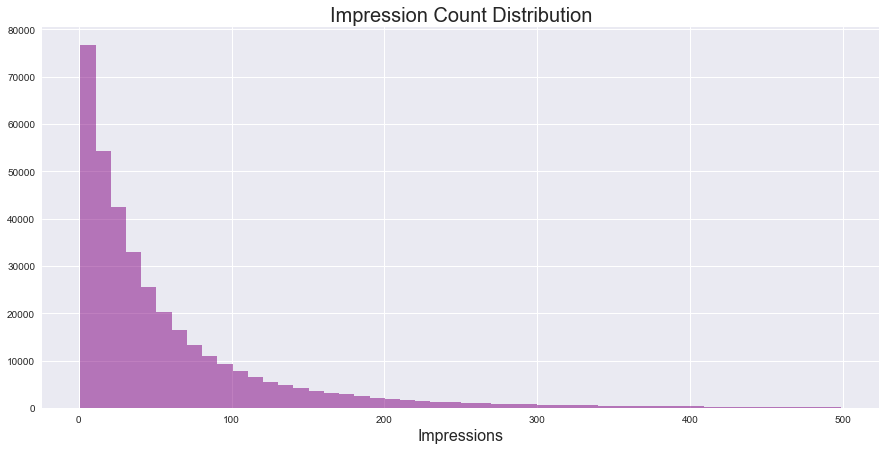

In [20]:
plt.style.use('seaborn')
plt.figure(figsize=(15, 7))
plt.title('Impression Count Distribution', size = 20)
plt.hist(user_impression_count[user_impression_count < 500], bins = 50, color = 'purple', alpha = 0.5)
plt.xlabel('Impressions', size = 16)
plt.show()

In [21]:
imp_per_user = user_impression_count.value_counts().sort_values(ascending=False)
print('Percentage of users with more than 10 impressions', 100*imp_per_user[imp_per_user.index > 9].sum() / imp_per_user.sum())

Percentage of users with more than 10 impressions 80.7821940107723


## Decreasing our Training Set size

Decrease our training set size to 100000 to save runtime.  

In [22]:
import numpy as np

random_sample = user_impression_count.sample(100000, random_state=420).reset_index()
random_sample.columns = ['uid', 'impressions_per_user']

df2 = df.merge(random_sample, how = 'inner', on = 'uid').reset_index(drop = True)

In [23]:
df2.head()

,uid,oid_nid,install_date,d0_time,d7_time,d0_spend,label_install,ts,pid,ecpm,...,d26,d27,d28,d29,d30,d31,d32,d33,d34,impressions_per_user
0,cf776590-4b43-469e-a7a8-16e55f40491b,4172_mistplay,2021-02-03,5618263,7231097,1.99,1,1612333875556,com.superplaystudios.dicedreams,0.058709,...,0.291392,0.193514,0.765365,0.308161,0.085101,0.382914,-0.175286,0.134823,0.183003,159
1,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,1612689397583,com.pieyel.scrabble,0.034666,...,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283,159
2,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,1612145228013,com.pieyel.scrabble,0.034666,...,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283,159
3,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,1612434023634,com.pieyel.scrabble,0.034666,...,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283,159
4,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,1612667920723,com.pieyel.scrabble,0.034666,...,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283,159


In [24]:
df2['has_user_installed_a_game'] = df2.groupby('uid')['label_install'].transform(max)

print('Percentage of users who install a game after impressions -> ' , df2.groupby('uid')['label_install'].max().mean())

Percentage of users who install a game after impressions ->  0.30615


In [25]:
df_final = df2[(df2['impressions_per_user'] > 9) & (df2['has_user_installed_a_game']==1)].copy()

In [26]:
df_final.drop(['impressions_per_user','has_user_installed_a_game','ts'], axis=1, inplace=True)

In [27]:
df_final.head()

,uid,oid_nid,install_date,d0_time,d7_time,d0_spend,label_install,pid,ecpm,cpi,...,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34
0,cf776590-4b43-469e-a7a8-16e55f40491b,4172_mistplay,2021-02-03,5618263,7231097,1.99,1,com.superplaystudios.dicedreams,0.058709,4.5,...,-0.471526,0.291392,0.193514,0.765365,0.308161,0.085101,0.382914,-0.175286,0.134823,0.183003
1,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,-0.520273,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283
2,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,-0.520273,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283
3,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,-0.520273,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283
4,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,-0.520273,-0.157990,0.398254,0.408495,0.267115,0.216351,0.094021,-0.571569,0.519159,-0.133283


## Dealing with missing Muse vectors
We simply impute these missing values with the avg muse vector from their geo

In [28]:
default_df = pd.merge(users[['uid','country']], default_muse, left_on='country', right_on='lctr', how='left')

In [29]:
for i in range(35): # updated for muse 9e 
    users['u%i' % i] = users['u%i' % i].isnull().astype(int) * default_df['u%i' % i] + ((~users['u%i' % i].isnull()).astype(int)) * users['u%i' % i].fillna(0)

## Merging with user info
We can finally merge the offers-installs-impressions data with the user's data.

In [30]:
df_final = pd.merge(df_final, users, how='left', on='uid')

## Dummifying Countries

We group Scandinavian countries into one encoder and Oceanic countries into another. 

In [31]:
df_final['country'].unique()

array(['US', 'CA', 'GB', 'DE', 'FR', 'IT', 'AU', nan, 'ES', 'SE', 'PR',
       'NO', 'FI', 'DK', 'TN', 'BE', 'SG', 'EG', 'IR', 'NZ', 'MX', 'JP',
       'DZ', 'GG', 'CO'], dtype=object)

In [32]:
countries = pd.get_dummies(df_final['country'])[['US', 'CA', 'GB', 'FR', 'DE', 'IT', 'ES', 'DK', 'SE', 'NO', 'FI', 'AU', 'NZ', 'SG']]

In [33]:
countries['SC'] = (countries['DK'].astype(bool)\
                        | countries['SE'].astype(bool)\
                        | countries['NO'].astype(bool)\
                        | countries['FI'].astype(bool)).astype(int)

countries['OC'] = (countries['AU'].astype(bool)\
                  | countries['NZ'].astype(bool)\
                  | countries['SG'].astype(bool)).astype(int)

In [34]:
countries = countries[['US', 'CA', 'GB', 'FR', 'DE', 'IT', 'ES', 'SC', 'OC']]

In [35]:
df_final2 = df_final.merge(countries, left_index = True, right_index = True)
df_final2 = df_final2.drop('country', axis = 1)

In [36]:
# checking proportion of nulls in key parameters -> underage users are remove for GDPR purposes
df_final2[['pid','ldu','d0','u0','g0']].isnull().mean()

pid    0.000000
ldu    0.051185
d0     0.000000
u0     0.051185
g0     0.523370
dtype: float64

In [37]:
df_final2 = df_final2[~df_final2['ldu'].isnull()].copy()

In [38]:
df_final2.head()

,uid,oid_nid,install_date,d0_time,d7_time,d0_spend,label_install,pid,ecpm,cpi,...,g34,US,CA,GB,FR,DE,IT,ES,SC,OC
0,cf776590-4b43-469e-a7a8-16e55f40491b,4172_mistplay,2021-02-03,5618263,7231097,1.99,1,com.superplaystudios.dicedreams,0.058709,4.5,...,NaN,1,0,0,0,0,0,0,0,0
1,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,NaN,1,0,0,0,0,0,0,0,0
2,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,NaN,1,0,0,0,0,0,0,0,0
3,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,NaN,1,0,0,0,0,0,0,0,0
4,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,0,com.pieyel.scrabble,0.034666,6.0,...,NaN,1,0,0,0,0,0,0,0,0


## Creating the Min Cosine Similarity Feature
We compute minimum cosine similarity between a user's apps and their lfg. This gives us a sense of how well their lfg reflects their own preferred apps. 

In [59]:
### Run Once Only! 

sql_str = '''WITH a as (SELECT bp.uid, u0, u1, u2, u3, u4, u5, u6, u7, u8, u9, u10, u11, u12,
            u13, u14, u15, u16, u17, u18, u19, u20, u21, u22, u23, u24, u25, u26,
            u27, u28, u29, u30, u31, u32, u33, u34, d0, d1, d2, d3, d4, d5, d6, d7,
            d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22,
            d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, lfg.createdat
            FROM mistylearning.blackpanther_user_data as bp
            JOIN mistplayetl.users ON bp.uid = users.uid
            JOIN mistplayetl.appstats_lfg lfg ON bp.uid = lfg.uid
            LEFT JOIN mistplayetl.mistoffers offers ON lfg.offer_id = offers.offer_id
            JOIN mistylearning.gloria_v0_9e gloria on offers.pid = gloria.pid
            WHERE date(lfg.createdat) <=  date '2021-02-07'
                  and date(lfg.createdat) >= date '2021-02-01')

            SELECT distinct a.*
            FROM a
            INNER JOIN
                (SELECT uid, min(createdat) as mincreatedat 
                FROM a
                GROUP BY uid) grouped 
            ON a.uid = grouped.uid
            AND a.createdat = grouped.mincreatedat '''

lfg_gloria = cursor.execute(sql_str).as_pandas()

In [60]:
lfg_gloria.head()

,uid,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,d26,d27,d28,d29,d30,d31,d32,d33,d34,createdat
0,d763c9ed-a780-47cf-9786-6243401706af,-0.035236,-0.087276,-0.293020,0.192400,0.268191,-0.299759,-0.344558,0.127683,0.140588,...,0.573700,-0.194364,0.801232,-0.193324,-0.081422,0.809377,-0.306535,0.272896,0.597555,2021-02-05 18:02:46.608
1,0daab9b3-4079-48de-b624-0872f27ab6b9,-0.329250,0.351115,-0.159600,0.144484,0.200040,0.183057,-0.035577,0.175094,0.127942,...,0.573700,-0.194364,0.801232,-0.193324,-0.081422,0.809377,-0.306535,0.272896,0.597555,2021-02-01 09:31:47.382
2,95d20cb1-65ed-4916-9c91-bf96b9435d26,-0.081547,-0.214609,-0.094972,0.310807,0.222624,-0.182375,-0.242434,0.120283,0.212949,...,0.573700,-0.194364,0.801232,-0.193324,-0.081422,0.809377,-0.306535,0.272896,0.597555,2021-02-02 16:55:29.491
3,d88d0701-7cf8-44f0-94d1-37413ec34bf1,-0.277079,0.214942,-0.336499,0.224366,0.210052,0.094499,-0.438490,0.306119,0.045596,...,0.573700,-0.194364,0.801232,-0.193324,-0.081422,0.809377,-0.306535,0.272896,0.597555,2021-02-04 15:47:46.625
4,80496eef-a6d8-4009-94d5-b6daf2b98efa,-0.082801,0.290649,-0.158277,0.183038,0.119744,-0.284997,0.399645,0.017986,0.106240,...,0.337562,0.196319,0.449102,0.359409,-0.339963,0.160871,0.092297,0.480738,-0.153227,2021-02-03 08:16:48.573


In [61]:
import numpy as np

def min_cosine_sim(rawdata, dim):

    _g_imps =  rawdata[['d%i' % i for i in range( dim)]]
    _muse =  rawdata[['u%i' % i for i in range( dim)]]
    imp_vecs = _g_imps.to_numpy()
    muse_vecs = _muse.to_numpy()
    dot_imp_muse = np.multiply(imp_vecs, muse_vecs).sum(axis=1)
    norm_imp = np.linalg.norm(imp_vecs, axis=1)
    norm_muse = np.linalg.norm(muse_vecs, axis=1)
    cos_sim = dot_imp_muse / (norm_imp * norm_muse)
    grouped = pd.DataFrame(cos_sim, index= rawdata['uid'])
    grouped = grouped.groupby('uid').min()
    grouped.columns = ['min_cosine_sim']

    return  rawdata.merge(grouped, on = 'uid', how = 'inner')

lfg_gloria2 = min_cosine_sim(lfg_gloria, 35)

In [63]:
lfg_gloria2.to_pickle('lfg_gloria2.pkl')

In [39]:
## Run this to pull final vector set

lfg_gloria2 = pd.read_pickle('lfg_gloria2.pkl')

In [42]:
lfg_gloria2 = lfg_gloria2[['uid', 'min_cosine_sim']].groupby('uid').min().reset_index()

In [45]:
df_final3 = df_final2.merge(lfg_gloria2, on = 'uid', how = 'left')

### Removing outliers (um & ecpm)

In [46]:
df_final3['um'] = (df_final3['um'] > 12).astype(float) / 10 + (df_final3['um'] <= 12) * df_final3['um']

## Converting weird new pandas types

In [47]:
# got to do this to convert weird ew PdInt64 type
def convert_new_pandas_int_type(df):
    for col in df.columns:
        col_dtype = df[col].dtype 
        try:               
            if col_dtype == pd.Int8Dtype():
                df[col] = df[col].astype('int8')
            elif col_dtype == pd.Int16Dtype():
                df[col] = df[col].astype('int16')
            elif col_dtype == pd.Int32Dtype():
                df[col] = df[col].astype('int32')    
            elif col_dtype == pd.Int64Dtype():
                df[col] = df[col].astype('int64')
            else:
                pass
        except Exception as err:
            #print('Shit for ', col, ', error : ', err)
            pass
    return df

df_final3 = convert_new_pandas_int_type(df_final3);
users = convert_new_pandas_int_type(users);

## Pickling the Final Dataset

The final dataset for the model!

In [52]:
df_final3 = df_final3[['uid', 'oid_nid', 'install_date', 'd0_time', 'd7_time', 'd0_spend', 
                       'pid', 'ecpm', 'cpi', 'um', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6',
                       'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17',
                       'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28',
                       'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'ldu', 'os', 'age', 'female', 'male',
                       'organic', 'u0', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 
                       'u10', 'u11', 'u12', 'u13', 'u14', 'u15', 'u16', 'u17', 'u18', 'u19', 
                       'u20', 'u21', 'u22', 'u23', 'u24', 'u25', 'u26', 'u27', 'u28', 'u29', 
                       'u30', 'u31', 'u32', 'u33', 'u34', 'g0', 'g1', 'g2', 'g3', 'g4', 'g5',
                       'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16',
                       'g17', 'g18', 'g19', 'g20', 'g21', 'g22', 'g23', 'g24', 'g25', 'g26', 'g27',
                       'g28', 'g29', 'g30', 'g31', 'g32', 'g33', 'g34', 'US', 'CA', 'GB', 'FR', 
                       'DE', 'IT', 'ES', 'SC', 'OC', 'min_cosine_sim', 'label_install']]

In [58]:
df_final3.head()

,uid,oid_nid,install_date,d0_time,d7_time,d0_spend,pid,ecpm,cpi,um,...,CA,GB,FR,DE,IT,ES,SC,OC,min_cosine_sim,label_install
0,cf776590-4b43-469e-a7a8-16e55f40491b,4172_mistplay,2021-02-03,5618263,7231097,1.99,com.superplaystudios.dicedreams,0.058709,4.5,4.0,...,0,0,0,0,0,0,0,0,NaN,1
1,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,com.pieyel.scrabble,0.034666,6.0,4.0,...,0,0,0,0,0,0,0,0,NaN,0
2,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,com.pieyel.scrabble,0.034666,6.0,4.0,...,0,0,0,0,0,0,0,0,NaN,0
3,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,com.pieyel.scrabble,0.034666,6.0,4.0,...,0,0,0,0,0,0,0,0,NaN,0
4,cf776590-4b43-469e-a7a8-16e55f40491b,3517_mistplay,NaT,0,0,0.00,com.pieyel.scrabble,0.034666,6.0,4.0,...,0,0,0,0,0,0,0,0,NaN,0


In [53]:
df_final3.drop(['install_date'], axis=1).to_pickle('bp_dataset_v0_3.pkl')

# Some exploration

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'d0'}>],
       [<AxesSubplot:title={'center':'ecpm'}>,
        <AxesSubplot:title={'center':'u0'}>],
       [<AxesSubplot:title={'center':'um'}>, <AxesSubplot:>]],
      dtype=object)

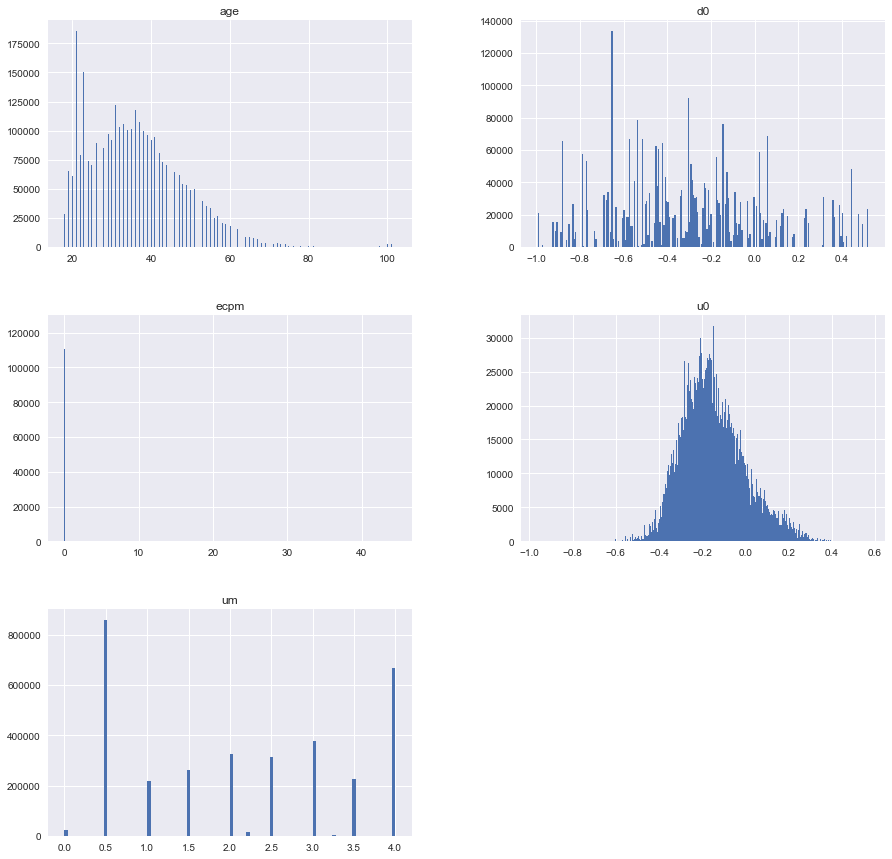

In [54]:
df_final3[['ecpm','um','d0','u0','age']].hist(bins='auto', figsize=(15,15))

In [10]:
pd.read_csv('Gloria_mistplay_games_v0-9b.csv')

,pid,d0,d1,d2,d3,d4,d5,d6,d7,d8,...,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24
0,Draziw.Button.Mines,-0.386184,-0.015685,-0.390437,0.269607,-0.018014,-0.549688,0.245262,0.274649,-0.178863,...,0.601003,0.224710,-0.038613,0.323700,-0.316062,-0.363332,0.045562,0.079350,0.314512,0.261489
1,Fi_Mobile.Dupaco,0.188442,0.119230,-0.317708,0.660493,-0.423452,-0.083908,0.234071,-0.200454,0.386705,...,-0.487150,0.019560,0.149526,-0.166968,0.230674,-0.133122,-0.129630,0.073812,-0.062871,0.059625
2,a.envisionmobile.caa,0.118468,-0.274726,0.049771,0.307735,-0.325548,-0.027100,0.218036,0.467909,-0.047663,...,-0.349989,-0.453381,0.553401,0.012014,-0.727878,0.266128,-0.316237,0.070929,-0.175118,0.274879
3,aa.apps.free.dailyreflections,-0.356613,0.098408,-0.337084,0.164205,-0.473749,0.531179,0.141385,0.291104,0.197217,...,-0.258378,-0.428737,-0.353635,-0.462698,-0.094306,0.034496,-0.213122,0.088295,-0.138319,-0.061038
4,aasuited.net.word,-0.690271,-0.050310,-0.511364,-0.109437,0.222142,-0.489543,0.127201,0.569554,0.181619,...,0.091733,-0.194132,-0.372416,0.469977,-0.040346,0.146199,-0.190482,0.210072,0.524282,0.300565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20928,Comics,-0.148513,0.084940,0.235900,0.312013,0.302430,-0.351753,0.069500,-0.221132,-0.307141,...,0.222809,-0.199519,-0.496222,0.049089,-0.174213,-0.044207,0.251077,0.176412,-0.185550,-0.207477
20929,Dating,0.039247,0.156476,-0.336957,-0.038267,-0.189023,0.210122,0.567648,-0.504755,0.171022,...,0.225482,-0.316695,-0.302814,0.053752,0.104897,0.465812,-0.195762,0.279200,-0.084227,0.151539
20930,Beauty,-0.165706,-0.056814,0.132027,-0.227765,-0.143337,-0.034006,-0.105286,-0.291223,-0.019254,...,-0.218024,-0.061810,-0.202583,-0.210603,-0.391081,0.038030,-0.110180,0.002875,0.025880,0.249755
20931,Events,-0.230866,-0.253383,-0.035640,0.191938,-0.164562,-0.248742,0.375901,-0.111711,-0.170686,...,-0.186955,-0.017794,-0.047919,-0.301000,-0.697619,0.016489,-0.076977,0.121938,-0.168083,0.471459


In [13]:
pd.read_csv('default_muse_vector_v03.csv').to_pickle('default_muse_vector_v03.pkl')